__Multinest Black Magic__

In this tutorial, I want to show you what I call 'MultiNest black magic'. Basically, there are ways to get MultiNest to run fast. Really fast. I'm talking 30-40x faster than all of the previous tutorials!

However, it comes with risks, and its important you develop an intuition for how this black magic works, so that you know when it is and isn't appropriate to use it.

But, before we think about that, lets run two phase's - one without black magic, and one with black magic. These runs will use the same prior config files (see 'chapter_2_lens_modeling/configs/7_multnest_black_magic'), thus any speed up in our phase's is not due to prior tuning.

In [ ]:
%matplotlib inline

import autofit as af
from autolens.pipeline.phase import phase_imaging
from autolens.model.galaxy import galaxy_model as gm
from autolens.data import ccd
from autolens.data import simulated_ccd
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.data.plotters import ccd_plotters
from autolens.lens.plotters import lens_fit_plotters

import time

# You need to change the path below to the chapter 1 directory.
chapter_path = "/path/to/user/autolens_workspace/howtolens/chapter_2_lens_modeling/"

chapter_path = "/home/jammy/PycharmProjects/PyAutoLens/workspace/howtolens/chapter_2_lens_modeling/"

# This sets up the config files used by this tutorial, and the path where the output of the modeling is placed.
af.conf.instance = af.conf.Config(
    config_path=chapter_path + "configs/7_multinest_black_magic",
    output_path=chapter_path + "output",
)

This function simulates the image we'll fit in this tutorial - which unlike previous tutorial images, also includes the light-profile of the lens galaxy.

In [ ]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.from_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grid_stack = grids.GridStack.from_shape_pixel_scale_and_sub_grid_size(
        shape=(130, 130), pixel_scale=0.1, sub_grid_size=2
    )

    lens_galaxy = g.Galaxy(
        redshift=0.5,
        light=lp.EllipticalSersic(
            centre=(0.0, 0.0),
            axis_ratio=0.8,
            phi=45.0,
            intensity=0.2,
            effective_radius=0.8,
            sersic_index=3.0,
        ),
        mass=mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=1.6
        ),
    )

    source_galaxy = g.Galaxy(
        redshift=1.0,
        light=lp.EllipticalSersic(
            centre=(0.0, 0.0), intensity=0.2, effective_radius=0.2
        ),
    )

    tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
        galaxies=[lens_galaxy, source_galaxy],
        image_plane_grid_stack=image_plane_grid_stack,
    )

    ccd_simulated = simulated_ccd.SimulatedCCDData.from_tracer_and_exposure_arrays(
        tracer=tracer,
        pixel_scale=0.1,
        exposure_time=300.0,
        psf=psf,
        background_sky_level=0.1,
        add_noise=True,
    )

    return ccd_simulated

Simulate the image and set it up.

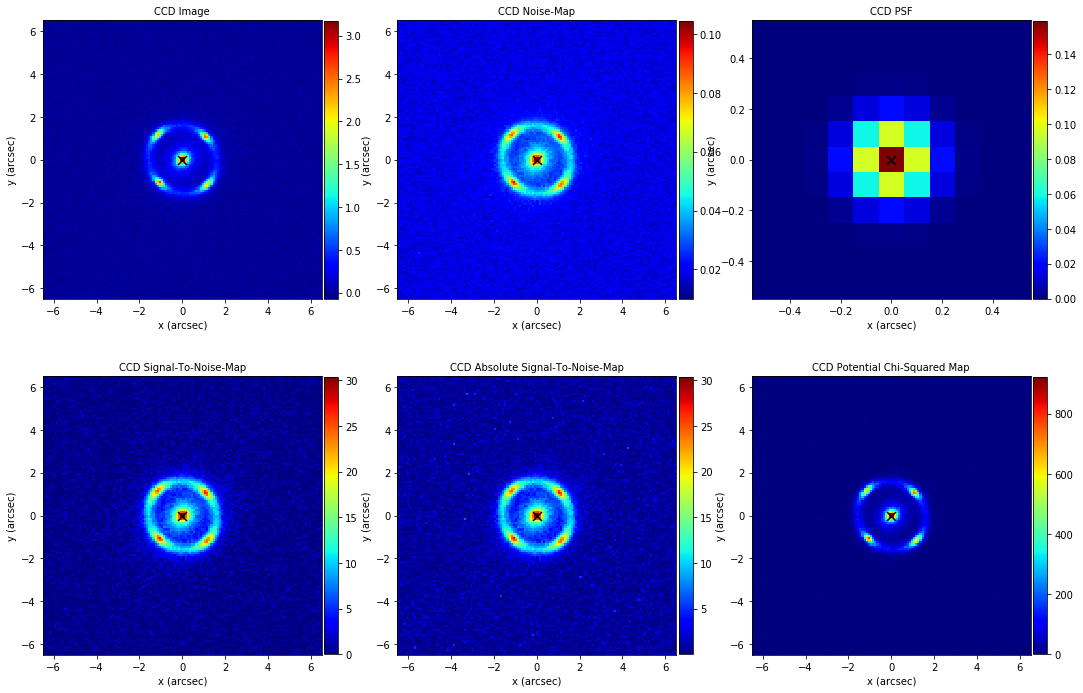

In [ ]:
ccd_data = simulate()

ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

Lets first run the phase without black magic, which is performed using the standard lines of code we're used to.

A word of warning, this phase takes >1 hour to run... so if you get bored, skip the run cell below continue to the phase with black magic (afterall, the whole point of this tutorial is how slow MultiNest can run, so theres no harm if the slow run speed bores you to tears :P).


In [ ]:
phase_normal = phase_imaging.PhaseImaging(
    phase_name="7_no_black_magic",
    galaxies=dict(
        lens=gm.GalaxyModel(
            redshift=0.5, light=lp.EllipticalSersic, mass=mp.EllipticalIsothermal
        ), 
        source=gm.GalaxyModel(redshift=1.0, light=lp.EllipticalSersic)
    ),
    optimizer_class=af.MultiNest,
)

We're going to use the time module to time how long each MultiNest run takes. However, if you resume the MultiNest run from a previous job, this time won't be accurate. Fortunately, if you look in the folder 'howtolens/chapter_2_lens_modeling/output/7_no_black_magic') you'll find a file 'run_time' which gives the overall run-time including any resumes.

In [ ]:
start = time.time()

Lets run the phase - the run-time will be output to the 'output/7_multinest_black_magic/' folder

In [ ]:
print(
    "MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/7_multinest_black_magic"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!"
)

phase_normal_results = phase_normal.run(data=ccd_data)

print("MultiNest has finished run - you may now continue the notebook.")

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/7_multinest_black_magic folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!
MultiNest has finished run - you may now continue the notebook.


Lets check we get a reasonably good model and fit to the data.

In [ ]:
lens_fit_plotters.plot_fit_subplot(
    fit=phase_normal_results.most_likely_fit,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=phase_normal_results.most_likely_fit,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

print("Time without black magic = {}".format(time.time() - start))

NameError: name 'phase_normal_results' is not defined

Now lets run the phase with black magic on, which will hopefully run a lot faster than the previous phase.

In [ ]:
phase_black_magic = phase_imaging.PhaseImaging(
    phase_name="7_with_black_magic",
    galaxies=dict(
        lens=gm.GalaxyModel(
            redshift=0.5, light=lp.EllipticalSersic, mass=mp.EllipticalIsothermal
        ), 
        source=gm.GalaxyModel(redshift=1.0, light=lp.EllipticalSersic)
    ),
    optimizer_class=af.MultiNest,
)

And herein lies the black magic. The changes to n_live_points and sampling efficiency are part of it, but its the constant efficiency mode wehre the real magic lies. However, lets not worry about whats happening just let, I will explain all in a moment.

In [ ]:
phase_black_magic.optimizer.n_live_points = 60
phase_black_magic.optimizer.sampling_efficiency = 0.5
phase_black_magic.optimizer.const_efficiency_mode = True

Lets reset our timer.

In [ ]:
start = time.time()

Lets run the phase - the run-time will be output to the 'output/7_multinest_black_magic/' folder

In [ ]:
print(
    "MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/7_multinest_black_magic"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!"
)

phase_black_magic_results = phase_black_magic.run(data=ccd_data)

print("MultiNest has finished run - you may now continue the notebook.")

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/7_multinest_black_magic folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!
MultiNest has finished run - you may now continue the notebook.


Of course the key question is, does our use of black magic impact the quality of our fit to the data?

In [ ]:
lens_fit_plotters.plot_fit_subplot(
    fit=phase_black_magic_results.most_likely_fit,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=phase_black_magic_results.most_likely_fit,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

print("Time with black magic = {}".format(time.time() - start))

NameError: name 'phase_black_magic_results' is not defined

And there we have it, a speed up of our non-linear search of at least x30! Something about constant efficiency mode has lead to a huge speed up in our MultiNest search. So, what happened? How did we get such a large increase in run speed?

To begin, we should think a bit more about how MultiNest works. Essentially, MultiNest first 'maps out' parameter space over large scales, using a set of live points (the number of which is defined by n_live_points). From these points it assesses what it thinks parameter space looks like, and where it thinks the highest likelihood regions of parameter space are. Then, MultiNest 'guesses' on average more lens models from these higher likelihood regions of parameter space, with the hope that its live points will slowly converge around the maximum likelihood solution(s).

How fast does MultiNest try to converge around these solutions? That is set by its sampling_efficiency. For example, a sampling efficiency of 0.3 means that MultiNest targets that 30% of its sample will result in 'accepted' live points (e.g. that they successfully sample a likelihood above at least one existing live point). For an efficiency of 0.8, it'd do this 80% of the time. Clearly, the higher our efficiency, the faster MultiNest samples parameter space.

However, if MultiNest is not confident it has a sufficiently good mapping out of parameter space that it can begin to converge around solutions using the input sampling_efficiency, it will lower the efficiency so as to more thoroughly map out parameter space. This is what is happening with the black magic switched off - the sampling efficiency doesn't retain the input value of 0.5 (50%), but instead drops dramtically to values of <5% by the end of the analysis. No longer it took so long to run, it took a HUGE amount of samples!

The thing is, MultiNest doesn't really need to drop its acceptance rate - its just confused by the noisy and unsmooth parameter spaces we typically sample in lens modeling. A non linear sampler, like MultiNest, is expecting to see a perfectly smooth parameter space with no stochastic variation between two points close to one another in parameter space (e.g. a parametric space defined by a smooth analytic function f(x, y, z) = x^2 + y^3 - 4z^2). The parameter space we sample in lens modeling is not at all smooth - and this upsets MultiNest to the point that is grinds its sampling rate to a halt.

Enter, constant efficiency sampling mode! This mode *forces* MultiNest to retain the sampling efficiency acceptance rate, regardless of whether or not it *thinks* it has a sufficiently good mapping out of parameter space. This gives us the huge speed up (as we saw for the black magic phase above), whilst ensuring we still compute an accurate lens model (because MultiNest had mapped out parameter space well enough, it just didn't know it). Therefore, MultiNest black magic is us basically 'tricking' MultiNest into not worrying too much about how thoroughly it samples parameter space, and its an extremely powerful tool to keep run-times with PyAutoLens manageable.


Of course, there are caveats and care must be taken. When we use constant efficiency mode, there is now the possibility that MultiNest will converge on a local maxima in parameter space and not be aware of it. We can see this by aggresively increasing the sampling efficiency and reducing the number of live points.

In [ ]:
phase_too_much_black_magic = phase_imaging.PhaseImaging(
    phase_name="7_with_too_much_black_magic",
    galaxies=dict(
        lens=gm.GalaxyModel(
            redshift=0.5, light=lp.EllipticalSersic, mass=mp.EllipticalIsothermal
        ), 
        source=gm.GalaxyModel(redshift=1.0, light=lp.EllipticalSersic)
    ),
    optimizer_class=af.MultiNest,
)

phase_too_much_black_magic.optimizer.n_live_points = 10
phase_too_much_black_magic.optimizer.sampling_efficiency = 0.95
phase_too_much_black_magic.optimizer.const_efficiency_mode = True

Reset our timer.

In [ ]:
start = time.time()

Lets run the phase - the run-time will be output to the 'output/7_multinest_black_magic/' folder.

In [ ]:
print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/7_multinest_black_magic'
      ' folder for live output of the results, images and lens model.'
      ' This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')

phase_too_much_black_magic_results = phase_too_much_black_magic.run(data=ccd_data)

print('MultiNest has finished run - you may now continue the notebook.')

lens_fit_plotters.plot_fit_subplot(
    fit=phase_too_much_black_magic_results.most_likely_fit,  should_plot_mask=True, 
    extract_array_from_mask=True, zoom_around_mask=True)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=phase_too_much_black_magic_results.most_likely_fit, should_plot_mask=True, 
    extract_array_from_mask=True, zoom_around_mask=True)

print("Time with too much black magic = {}".format(time.time() - start))

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/7_multinest_black_magic folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!


ValueError: could not convert string to float: '-0.100000000000000002+101   '

Clearly, the phase ran super fast, but it gave us the incorrect lens model - therefore we must use black magic with care!

So, when should we use black magic, and when shouldn't we? I generally follow the guidelines below:

1) When the dimensionality of parameter space is small < ~15 parameters.

2) If the parameter space is > ~15 parameters, when the priors on the majority of model parameters are initialized using Gaussian priors centred on an accurate model.

3) When the lens model doesn't have high dimensionality degeneracies between different parameter (We'll expand on this in later chapters).

Finally, its worth emphasizing that when we cover pipelines in chapter 3 (I know I keep mentioning this, we will get there eventally!) that this black magic is extremely powerful. As we discussed in the previous tutorial, the whole premise of pipelines is we 'initialize' the lens model using a less accurate but more efficienct analysis, and worry about getting the results 'perfect' at the end. Getting the early phases of that analysis to run in constant efficiency mode is just another tool to keep things running fast.